# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [581]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pylab

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [582]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк
df=pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

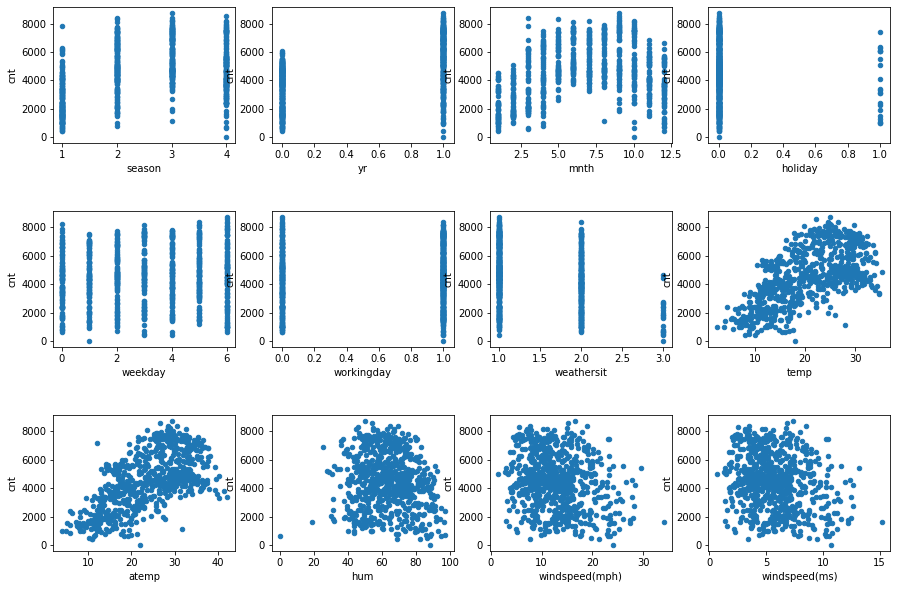

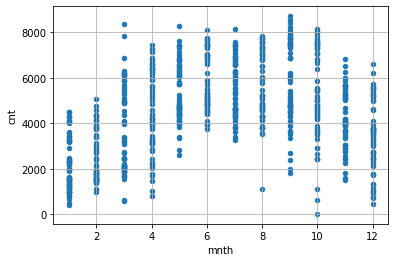

In [583]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])
df.plot(x='mnth', y='cnt',kind='scatter')
pylab.grid(True)

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: Скорее всего, данную зависимость можно аппроксимировать параболой, тогда зависимость - квадратичная.
   * Или же, если "смотреть в лоб" (имея перед собой просто множество точек), то можно оценить зависимость, как множество функций Дирака ("дельта"-функций"), реализованных с запаздыванием в 1 месяц (при этом амплитуда - очень высока, но не уходит в бесконечность)
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: Температура наружного воздуха (temp), Температура наружного воздуха (согласно ощущениям) (atemp). 

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [584]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
df.iloc[:,:-1].corrwith(df['cnt'], method='pearson')

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [585]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df.iloc[:,7:13].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [586]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
df.mean(axis=0)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [587]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [588]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [589]:
from sklearn.linear_model import LinearRegression

In [590]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns

# Firstly, build and train linear regression model
lin_regressor = LinearRegression()
lin_regressor.fit(X,y)
# Next step, make a function which will return resultings coefficients
def regressor_result_coef(regressor):
    for columns, coef in zip(df.columns[:-1],regressor.coef_):
        print(columns,coef)
regressor_result_coef(lin_regressor)

season 570.8681698112806
yr 1021.9637175294769
mnth -141.30232005185658
holiday -86.76357810238395
weekday 137.2291962130855
workingday 56.38823527436251
weathersit -330.2316126526911
temp 367.4749136050979
atemp 585.5563613048682
hum -145.60790584172227
windspeed(mph) 12458830091266.607
windspeed(ms) -12458830091465.062


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [591]:
from sklearn.linear_model import Lasso, Ridge

In [593]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса

#building and training of linear regression model with L1-regularization
L1_regressor = Lasso()
L1_regressor.fit(X,y)
regressor_result_coef(L1_regressor)

season 560.241616030887
yr 1019.4634940657196
mnth -128.7306270367875
holiday -86.15278133371096
weekday 137.34789390496329
workingday 55.21237064135668
weathersit -332.3698569623488
temp 376.3632362096987
atemp 576.5307935045507
hum -144.12915500348595
windspeed(mph) -197.13968940248608
windspeed(ms) -2.8049652690829766e-08


In [594]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса

#building and training of linear regression model with L2-regularization
L2_regressor = Ridge()
L2_regressor.fit(X,y)
regressor_result_coef(L2_regressor)

season 563.0645722520176
yr 1018.9483787875288
mnth -131.87332028247695
holiday -86.74609799709272
weekday 138.005111178719
workingday 55.90311037506445
weathersit -332.34978849907355
temp 386.45788919194615
atemp 566.3470470600289
hum -145.0713272986722
windspeed(mph) -99.25944108175416
windspeed(ms) -99.25944115437945


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [595]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.

#Firstly, build and train linear regression with L1-regularization and L2-regularization  for each alpha
for alpha in enumerate(alphas):
    L1__regressor = Lasso(alpha = alpha[1])
    L1__regressor.fit(X,y)
    L2__regressor = Ridge(alpha = alpha[1])
    L2__regressor.fit(X,y)
    coefs_lasso[alpha[0]] = L1__regressor.coef_
    coefs_ridge[alpha[0]] = L2__regressor.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

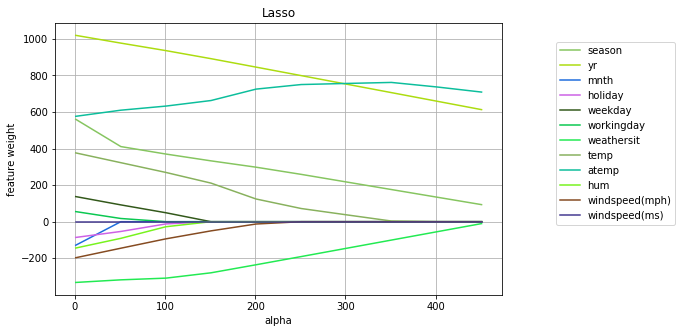

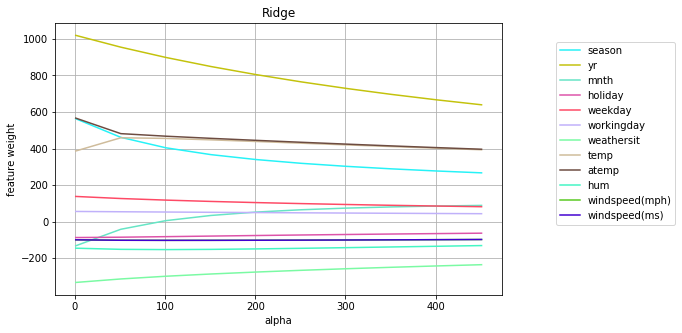

In [596]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")
pylab.grid(True)

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")
pylab.grid(True)

In [597]:
# ПЕРЕД ВАМИ ОБЛАСТИ С КОДОМ, НА КОТОРЫЕ ССЫЛАЮТСЯ ОТВЕТЫ НИЖЕ
#Code for question N_2
for columns, coef in zip(df.columns[:-1],coefs_lasso[9]):
    print(columns,coef)
df.iloc[:,:-1].corrwith(df['cnt'], method='pearson')

season 93.35174230494606
yr 613.0546392223404
mnth 0.0
holiday -0.0
weekday 0.0
workingday 0.0
weathersit -10.41856901538918
temp 0.0
atemp 709.1308770588871
hum -0.0
windspeed(mph) -0.0
windspeed(ms) -0.0


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

In [598]:
#Code for question N_3

#Lasso-regularization
L1_regressor = Lasso(alpha = 0.000001)
L1_regressor.fit(X,y)
print('Lasso-regularization:')
for columns, coef in zip(df.columns[10:12],L1_regressor.coef_[10:12]):
    print(columns, coef)
    if coef < 1.0e-3 and coef > -1.0e-3:
        print('Feature is excluded')
    else:
        print('Feature is not excluded')

#Ridge-regularization
L2_regressor = Ridge(alpha = 0.000001)
L2_regressor.fit(X,y)
print('Ridge-regularization:')
for columns, coef in zip(df.columns[10:12],L2_regressor.coef_[10:12]):
    print(columns, coef)
    if coef < 1.0e-3 and coef > -1.0e-3:
        print('Feature is excluded')
    else:
        print('Feature is not excluded')

Lasso-regularization:
windspeed(mph) -198.0705457142091
Feature is not excluded
windspeed(ms) -9.645497143362867e-08
Feature is excluded
Ridge-regularization:
windspeed(mph) -98.99875693508783
Feature is not excluded
windspeed(ms) -99.07178755419027
Feature is not excluded


Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: Как можно наблюдать из графиков: наибольное агрессивное снижение весов происходит при использовании L1-регуляризации, т.е. при использовании регуляризатора Lasso. Причина данного более агрессивного поведения описана ниже - при ответе на следующие вопросы.
2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: 2.1. Полученные веса, при большом значении L1-регуляризаторя = 451, представленны в следующей области (области кода #Code for question N_2). Также представлены и коэффициенты корреляции исследуемых признаков с значениями целевой функций(cnt). Как можно заметить, практически все веса перед неинформативными признаками и не совсем информативными признаками (коэффициент корреляции < 0.5) - практически обнулены.
    * 2.2. Почему происходит обнуление (сильное снижения значения) весов признаков? Рассмотрим функционал ошибки с применением L1-регуляризации: Q(w,x)= |Xw-y| + alpha*|w|. При увеличении регуляризатора alpha, так что его значение становится много больше |Xw-y|, ошибка: Q(w,x)~alpha*|w|, отсюда |w| =  Q(w,x)/alpha . Таким образом, с увеличением регуляризатора alpha значение весов признаков сильно снижается. Но, стоит отметить, что зависимость значения весов от alpha, на самом деле не имеет вид гладкой гиперболы, что следует из формулы, приведенной выше, а является кусочно-линейной.
3. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ:   Для осуществления выводов - расчитаем значения весов признаков при Lasso- и Ridge-регуляризации, устремив к нулю регуляризатор alpha (alpha = 0.000001) (см. область #Code for question N_3). Как можно увидеть, при любом бесконечно малом значении alpha>0 - можно утверждать, в случае L1-регуляризации один из признаков windspeed будет исключен (Feature is excluded). В случае же L2-регуляризации данного исключения происходить не будет (Feature is not excluded).
4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: 4.1. Для ответа на данный вопрос ,первоначально, обратимся к пункту 2.2. Как можно заметить, при увеличении регуляризатора alpha, в случае L1-регуляризации: |w| =  Q(w,x)/alpha. В случае же L2-регуляризации: |w| =  Q(w,x)/sqrt(alpha), что означает - что скорость снижения |w| при L1-регуляризации больше. 
    * 4.2. Далее, рассмотрим графики зависимости feature_weight(alpha). В случае L1-регуляризации зависимость представляет собой кусочно-линейную функцию, в случае L2-регуляризации - гладкую функцию гиберболического вида. Таким образом, с помощью L1-регуляризации (метод Lasso) появляется возможность "обнулить" веса неиформативных признаков и, тем самым, исключить данные признаки. В случае же L2-регуляризации (метод Ridge), зависимость feature_weight(alpha) будет стремиться к некой ассимптоте и обнулить, т.е. исключить неинформативные признаки не получится, конечно - при установке alpha в разумных пределах. Если же alpha устремить к бесконечности, то с помощью L2-регуляризации тоже можно исключить неинформативные признаки, (т.е. добиться   w < 1e-3).
    * Проанализировав п. 4.1 и п. 4.2, можно сделать вывод,что лучше всего для отбора неинформативных признаков подходит L-1 регуляризация (метод Lasso). L2-регуляризация (метод Ridge) для данной операции - неэффективна.

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [599]:
from sklearn.linear_model import LassoCV
from matplotlib import rcParams
import matplotlib

Optimal L1-regularizator alpha: 6
L1-regularization weights:
season 532.0189828413537
yr 1015.0602226430597
mnth -100.03952614356626
holiday -83.29395987529917
weekday 132.50446549095795
workingday 51.55708561407389
weathersit -330.5598567399813
temp 370.6798550300351
atemp 581.3969310654967
hum -140.0074055006887
windspeed(mph) -191.77140847135064
windspeed(ms) -2.6854518176296607e-08


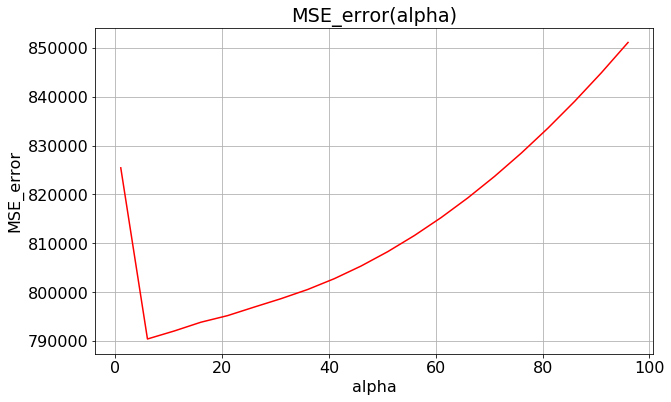

In [600]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)

#Firstly, Build and train linear regression model with L1-regularization
L1___regressor = LassoCV(alphas=alphas, cv=3).fit(X,y)

# Next step, build function mean_MSE(alpha) graphic
plt.figure(figsize=(10,6))
matplotlib.rcParams.update({'font.size': 16}) 
plt.plot(L1___regressor.alphas_, L1___regressor.mse_path_.mean(axis=1), label='MSE_error', color='r')
plt.xlabel("alpha")
plt.ylabel("MSE_error")
plt.title("MSE_error(alpha)")
pylab.grid(True)

#Printing optimal alpha
print('Optimal L1-regularizator alpha:', L1___regressor.alpha_ )

# Printing features weights
print('L1-regularization weights:')
for columns,coef in zip(df.columns[:-1],L1___regressor.coef_):
    print(columns, coef)

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [601]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_

#Firstly, determine L1-regularizators alpha, which are matched to MSE minimum on every sample
#Sorry, i couldn't optimize this code - if you have a decision, how to optimize it, please, connect with me.
for i in range(0,len(L1___regressor.mse_path_)):
    if L1___regressor.mse_path_[i][0] == L1___regressor.mse_path_.min(axis=0)[0]:
        print('Optimal L1-regularizator alpha on the first sample:',L1___regressor.alphas_[i])
    if L1___regressor.mse_path_[i][1] == L1___regressor.mse_path_.min(axis=0)[1]:
        print('Optimal L1-regularizator alpha on the second sample:',L1___regressor.alphas_[i])
    if L1___regressor.mse_path_[i][2] == L1___regressor.mse_path_.min(axis=0)[2]:
        print('Optimal L1-regularizator alpha on the third sample:',L1___regressor.alphas_[i])

Optimal L1-regularizator alpha on the first sample: 41
Optimal L1-regularizator alpha on the second sample: 6
Optimal L1-regularizator alpha on the third sample: 1


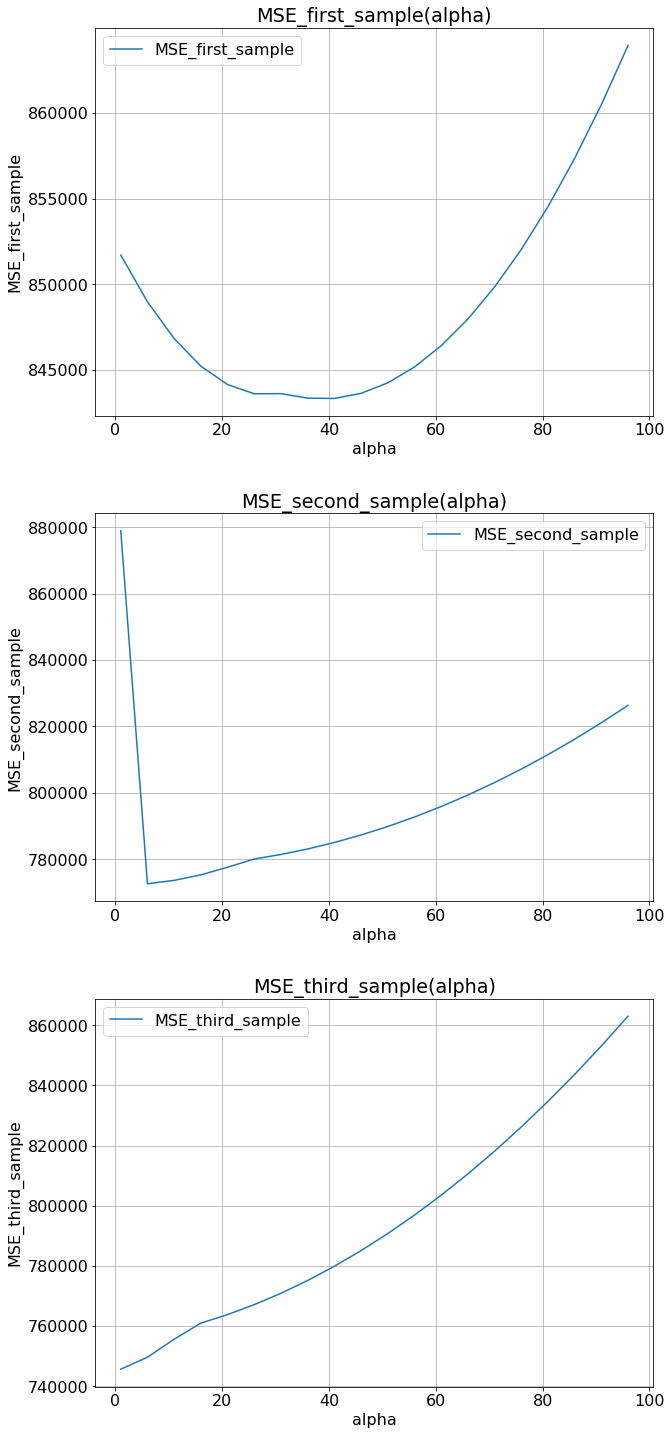

In [602]:
#Next step - determine and fill in the stacks with values of MSE from each sample
MSE_first_sample_stack=np.zeros(20)
MSE_second_sample_stack=np.zeros(20)
MSE_third_sample_stack=np.zeros(20)

for i in range(0,len(L1___regressor.mse_path_)):
    MSE_first_sample_stack[i] = L1___regressor.mse_path_[i][0]
    MSE_second_sample_stack[i] = L1___regressor.mse_path_[i][1]
    MSE_third_sample_stack[i] = L1___regressor.mse_path_[i][2]
    
#Now, build three plots of function: MSE = f(alpha) for three samples:
rcParams['figure.subplot.hspace']=0.25
rcParams['figure.figsize']=(10,25)
graphics = pylab.figure()
MSE_first_sample_plot = graphics.add_subplot(311)
MSE_first_sample_plot.plot(L1___regressor.alphas_,MSE_first_sample_stack, label = 'MSE_first_sample')
pylab.xlabel('alpha')
pylab.ylabel('MSE_first_sample')
pylab.title('MSE_first_sample(alpha)')
pylab.grid(True)
matplotlib.pyplot.legend()

MSE_second_sample_plot = graphics.add_subplot(312)
MSE_second_sample_plot.plot(L1___regressor.alphas_,MSE_second_sample_stack, label = 'MSE_second_sample')
pylab.xlabel('alpha')
pylab.ylabel('MSE_second_sample')
pylab.title('MSE_second_sample(alpha)')
pylab.grid(True)
matplotlib.pyplot.legend()

MSE_third_sample_plot = graphics.add_subplot(313)
MSE_third_sample_plot.plot(L1___regressor.alphas_,MSE_third_sample_stack, label = 'MSE_third_sample')
pylab.xlabel('alpha')
pylab.ylabel('MSE_third_sample')
pylab.title('MSE_third_sample(alpha)')
pylab.grid(True)
matplotlib.pyplot.legend()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: 1. Ниже (в поле кода) выведены четыре признака с наибольшими положительными коэффициентами, а также произведена визуализация зависимости количества прокатов велосипедов от данных признаков. 
    2. Проанализировав построенные зависимости, можно заметить, что линейная зависимость количества прокатов велосипедов прослеживается только от года, температуры наружного воздуха и температуры наружного воздуха по ощущениям. В случае же зависимости количества прокатов велосипедов от сезона - наблюдается квадратичный характер данной зависимости.
    3. Утвержать, что чем больше значение каждого из приведенных признаков, тем больше людей захотят взять велосипеды - нелогично, так как, например, признаки "год" и "сезон" - вообще являются категориальными, т.е. год может принимать значения не 0,1, а 2011,2012, при этом сезон может быть: весна, лето, осень, зима - следовательно, в случае, если признак: "год" или "сезон" - данное утверждение неправильно. Однако, можно сделать следующие выводы: в 2012-м году количество людей, желающих взять велосипед в прокат было больше, чем в 2011; летом и осенью - спрос на прокат влосипедов больше, чем осенью и зимой.
    4. В случае же, если рассматриваются вещественные признаки: "temp", "atemp" - то утверждать, что с увеличением их значения - увеличится количество прокатов, можно.


The highest values of model weights:
season 532.0189828413537
yr 1015.0602226430597
temp 370.6798550300351
atemp 581.3969310654967


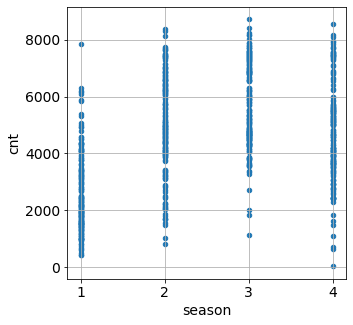

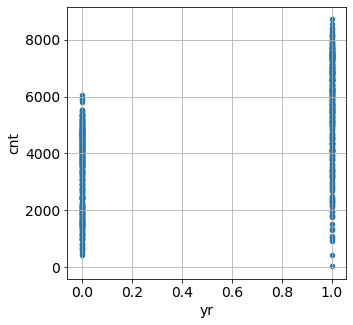

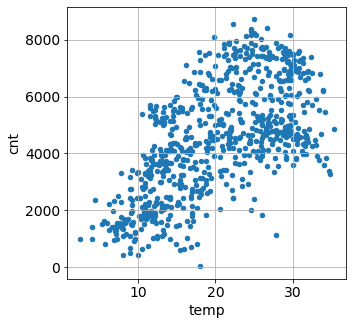

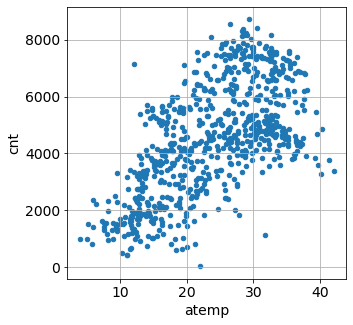

In [603]:
#Code for question N_1
# Printing features weights
print('The highest values of model weights:')
for columns,coef in zip(df.columns[0:2],L1___regressor.coef_[0:2]):
    print(columns, coef)
for columns,coef in zip(df.columns[7:9],L1___regressor.coef_[7:9]):
    print(columns, coef)

# Scatter_plots of function cnt = f(features) building
rcParams['figure.subplot.hspace']=0.5
rcParams['figure.figsize']=(5,5)
matplotlib.rcParams.update({'font.size': 14}) 
df.plot(x='season', y='cnt',kind='scatter')
plt.grid(True)
df.plot(x='yr', y='cnt',kind='scatter')
plt.grid(True)
df.plot(x='temp', y='cnt',kind='scatter')
plt.grid(True)
df.plot(x='atemp', y='cnt',kind='scatter')
plt.grid(True)

2. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: 1. Ниже (в поле кода) выведены три признака с наибольшими отрицательными коэффициентами, а также произведена визуализация зависимости количества прокатов велосипедов от данных признаков.
    2. Проанализировав построенные зависимости, можно заметить, что линейная зависимость количества прокатов велосипедов прослеживается от оценки благоприятности погоды, влажности воздуха, также можно проследить и линейную зависимость количества прокатов от скорости ветра.
    3. Опять же, если мы рассматриваем зависимость количества прокатов велосипедов от категориального признака - оценки благоприятности погоды, то должно быть следующее утверждение: если состояние погоды "ухудшается" спрос на прокат велосипедов будет снижаться.
    4. В случае же рассмотрения вещественных признаков: влажности воздуха и скорости ветра, то утвердждать, что с увеличением значений данных признаков спрос на прокат велосипедов будет падать - можно и это логично.


The highest negative values of model weights:
weathersit -330.5598567399813
hum -140.0074055006887
windspeed(mph) -191.77140847135064


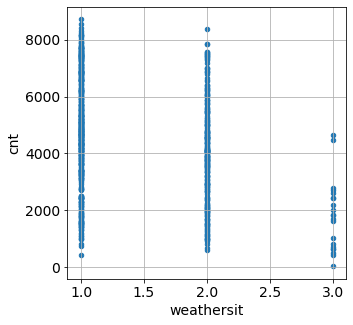

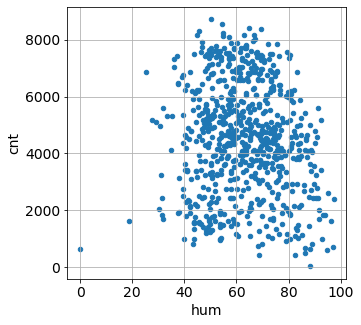

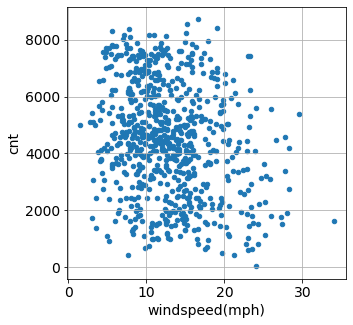

In [604]:
#Code for question N_2
# Printing features weights
print('The highest negative values of model weights:')
for columns,coef in zip(df.columns[6:7],L1___regressor.coef_[6:7]):
    print(columns, coef)
for columns,coef in zip(df.columns[9:11],L1___regressor.coef_[9:11]):
    print(columns, coef)

# Scatter_plots of function cnt = f(features) building
rcParams['figure.subplot.hspace']=0.5
rcParams['figure.figsize']=(5,5)
matplotlib.rcParams.update({'font.size': 14}) 
df.plot(x='weathersit', y='cnt',kind='scatter')
plt.grid(True)
df.plot(x='hum', y='cnt',kind='scatter')
plt.grid(True)
df.plot(x='windspeed(mph)', y='cnt',kind='scatter')
plt.grid(True)

3. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: Ниже (в поле кода) выведен признак, коэффициент которого меньше порогового значения 1e-3, т.е. признак "скорость ветра в м/с", который в результате L1-регуляризации был исключен из модели. Также произведена визуализация зависимости количества прокатов велосипедов от данного признака.
    2. Чтобы ответить на вопрос, почему после L1-регуляризации данный признак "скорость ветра в м/с" был исключен - обратимся к вычисленным коэффициентам корреляции количества прокатов велосипеда с влияющими признаками (см.ниже). Как можно заметить, существует идентичный признак "скорость ветра mph", с идентичным значением коэффициента корреляции. Ествевственно, оба рассматриваемых признака одинаково влияют на количество прокатов велосипедов, однако, рассмотрение их при построении модели регрессии привело бы к усложнению модели и возможному переобучению.
    3. Таким образом, в ходе L1-регуляризации (Lasso-метод), признак "скорость ветра в м/с" - был исключен.
    4. Почему же Lasso-метод (L1-регуляризация) исключил данный признак? И как он (метод) понял, что данный признак будет неполезен (неинформативен) для построения модели? Дело в том, что при реализации алгоритма Lasso - строится матрица ковариации для рассматриваемой выборки, благодаря которой при выполнении определенных условий - для дальнейшего расчета весов используются информативные признаки, веса же для неинформативных признаков устремляются к нулю ("обнуляются"). Более подробно математическая реализация алгоритма Lasso рассмотрена здесь: http://www.machinelearning.ru/wiki/images/7/7e/VetrovSem11_LARS.pdf 

The excluded features and their weights:
windspeed(ms) -2.6854518176296607e-08
Correlation coeffs:
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


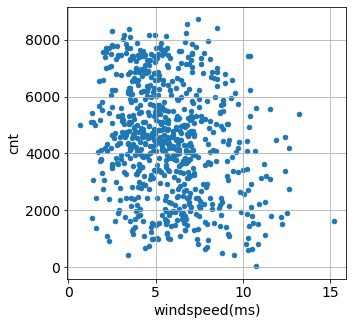

In [605]:
#Code for question N_3
# Printing features weights
print('The excluded features and their weights:')
for columns, coef in zip(df.columns[0:12],L1___regressor.coef_[0:12]):
    if coef < 1.0e-3 and coef > -1.0e-3:
        print(columns,coef)

# Printing correlation coeffs
print('Correlation coeffs:')
print(df.iloc[:,:-1].corrwith(df['cnt'], method='pearson'))

# Scatter_plots of function cnt = f(features) building
rcParams['figure.subplot.hspace']=0.5
rcParams['figure.figsize']=(5,5)
matplotlib.rcParams.update({'font.size': 14}) 
df.plot(x='windspeed(ms)', y='cnt',kind='scatter')
plt.grid(True)

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.